In [1]:
# Link to GitHub Repo: https://github.com/aleccwilliams810/AI-Healthcare.git

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
path = r"C:\Users\aleci\OneDrive\Desktop\AI in Healthcare\mimic-iii-clinical-database-demo-1.4\mimic-iii-clinical-database-demo-1.4"

In [4]:
patients_df = pd.read_csv(path + r"\PATIENTS.csv")

patients_df['dob'] = pd.to_datetime(patients_df['dob'], errors='coerce')
patients_df['dod'] = pd.to_datetime(patients_df['dod'], errors='coerce')

patients_df = patients_df[(patients_df['dob'].dt.year >= 1900)]

patients_df['age'] = np.floor_divide((patients_df['dod'] - patients_df['dob']).dt.days, 365)

In [5]:
labevents_df = pd.read_csv(path + r"\LABEVENTS.csv")

In [6]:
patient_lab_event_df = pd.merge(labevents_df, patients_df, on='subject_id')

In [7]:
patient_lab_event_df['flag'].value_counts(dropna=False)

flag
NaN         44905
abnormal    28727
delta         224
Name: count, dtype: int64

In [8]:
patient_lab_event_df['flag'] = patient_lab_event_df['flag'].fillna('no flag')

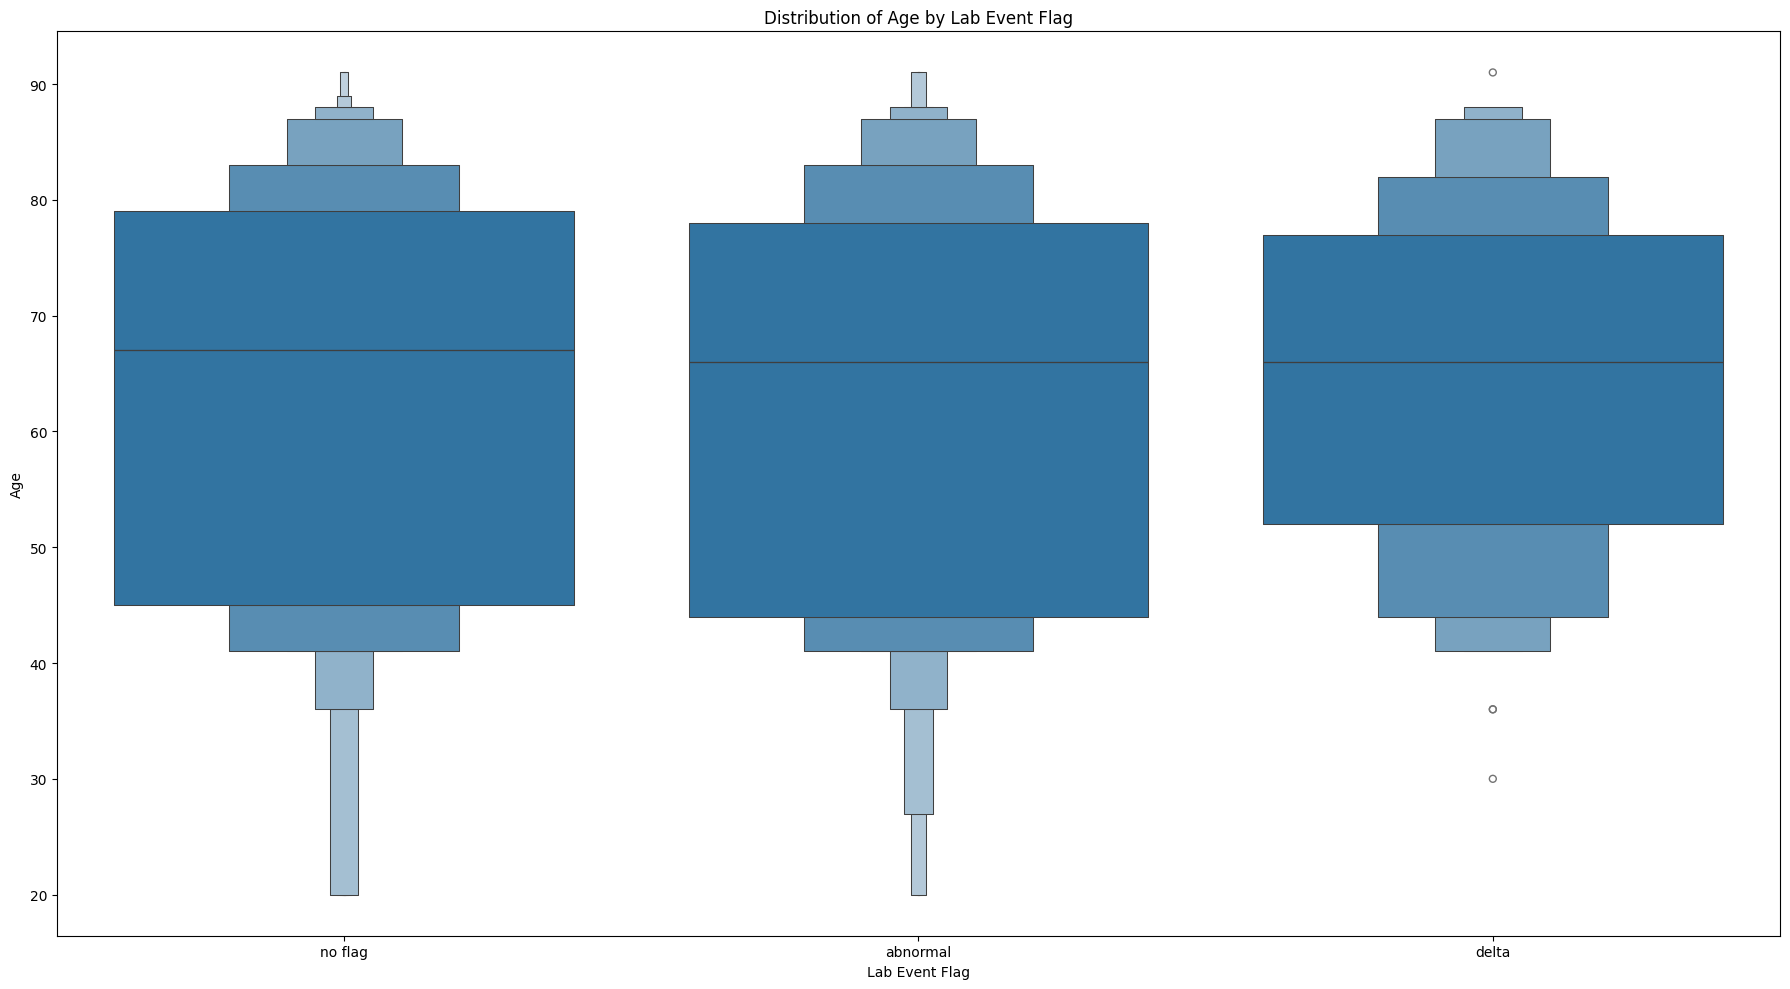

In [9]:
plt.figure(figsize=(18, 10))

sns.boxenplot(data=patient_lab_event_df, x='flag', y='age')
plt.xlabel('Lab Event Flag')
plt.ylabel('Age')
plt.title('Distribution of Age by Lab Event Flag')

plt.tight_layout()
plt.show()

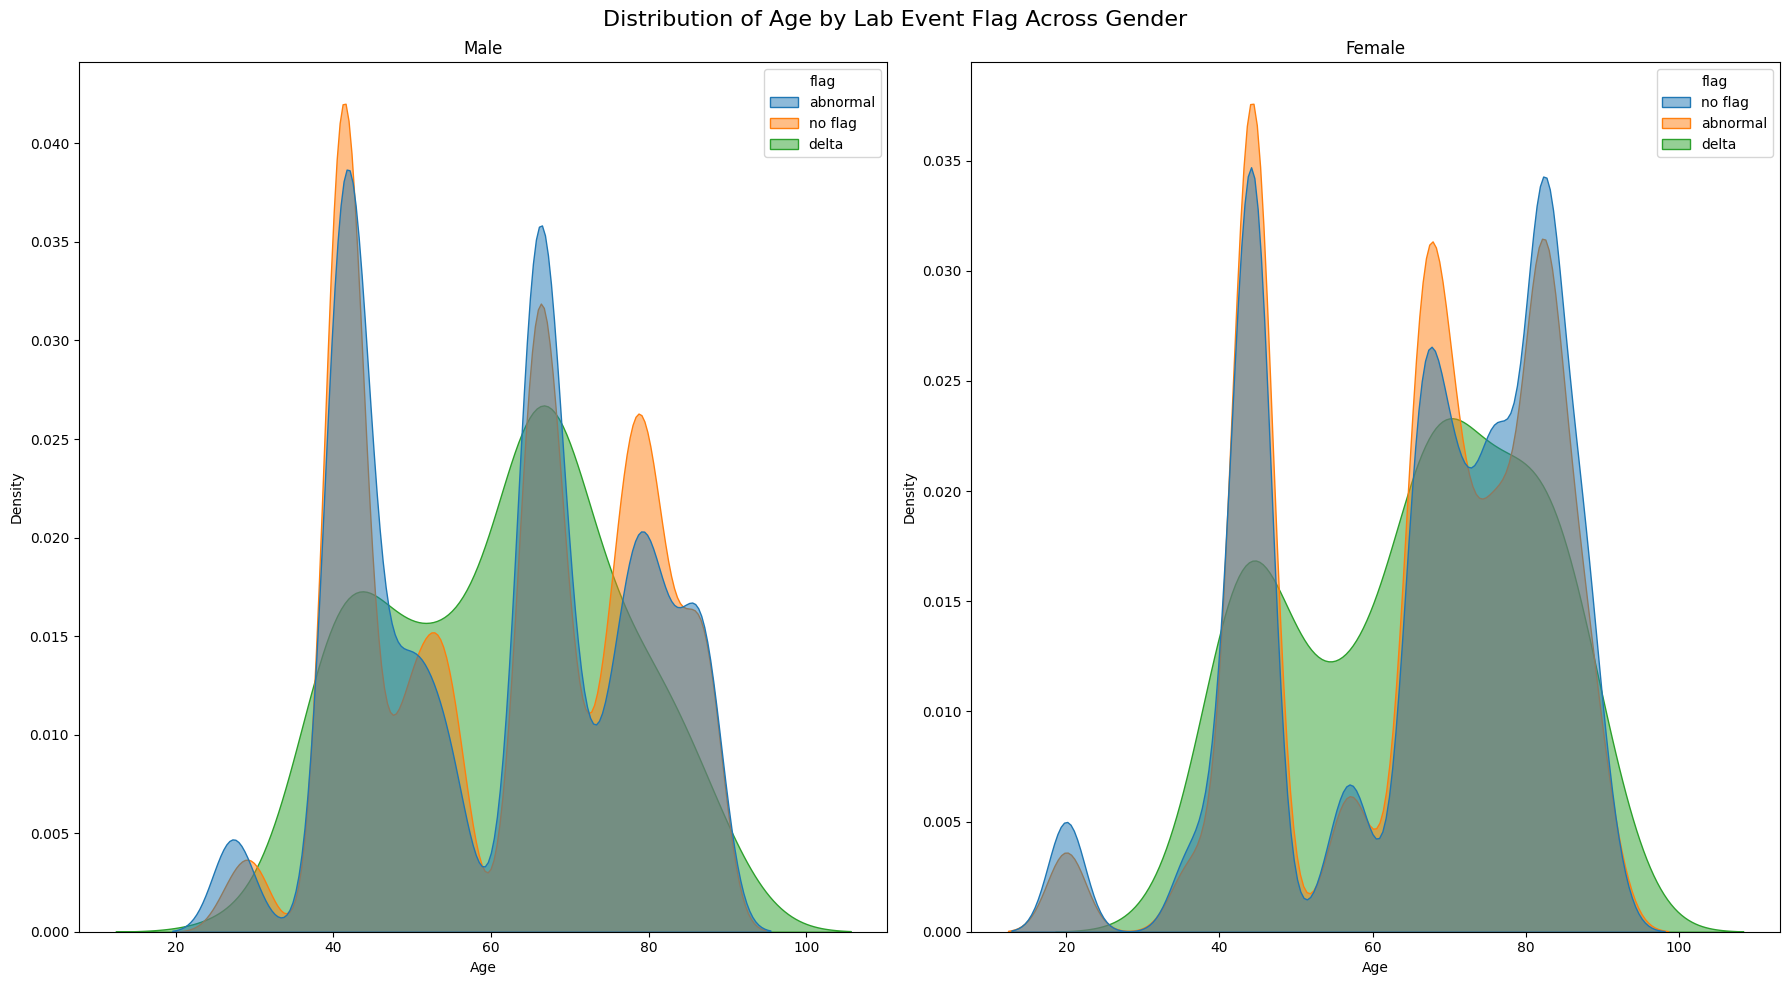

In [10]:
plt.figure(figsize=(18, 10))

plt.subplot(1,2,1)
sns.kdeplot(
    data=patient_lab_event_df[patient_lab_event_df['gender'] == 'M'], 
    x='age', 
    hue='flag', 
    common_norm=False, 
    fill=True, 
    alpha=0.5
)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title("Male")

plt.subplot(1,2,2)
sns.kdeplot(
    data=patient_lab_event_df[patient_lab_event_df['gender'] == 'F'], 
    x='age', 
    hue='flag', 
    common_norm=False, 
    fill=True, 
    alpha=0.5
)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title("Female")

plt.subplots_adjust(top=0.85)
plt.suptitle('Distribution of Age by Lab Event Flag Across Gender', fontsize=16)

plt.tight_layout()
plt.show()

In [11]:
cptevents_df = pd.read_csv(path + r"\CPTEVENTS.csv")

cptevents_df['subsectionheader'].value_counts()


subsectionheader
Hospital inpatient services                                                                                                                                                  739
Critical care services                                                                                                                                                       326
Pulmonary                                                                                                                                                                    291
Consultations                                                                                                                                                                 77
Dialysis                                                                                                                                                                      50
Cardiovascular system                                                                             

In [12]:
cptevents_filtered = cptevents_df[cptevents_df['subsectionheader'] == 'Critical care services']
patient_cpt_event_df = pd.merge(cptevents_filtered, patients_df, on='subject_id')

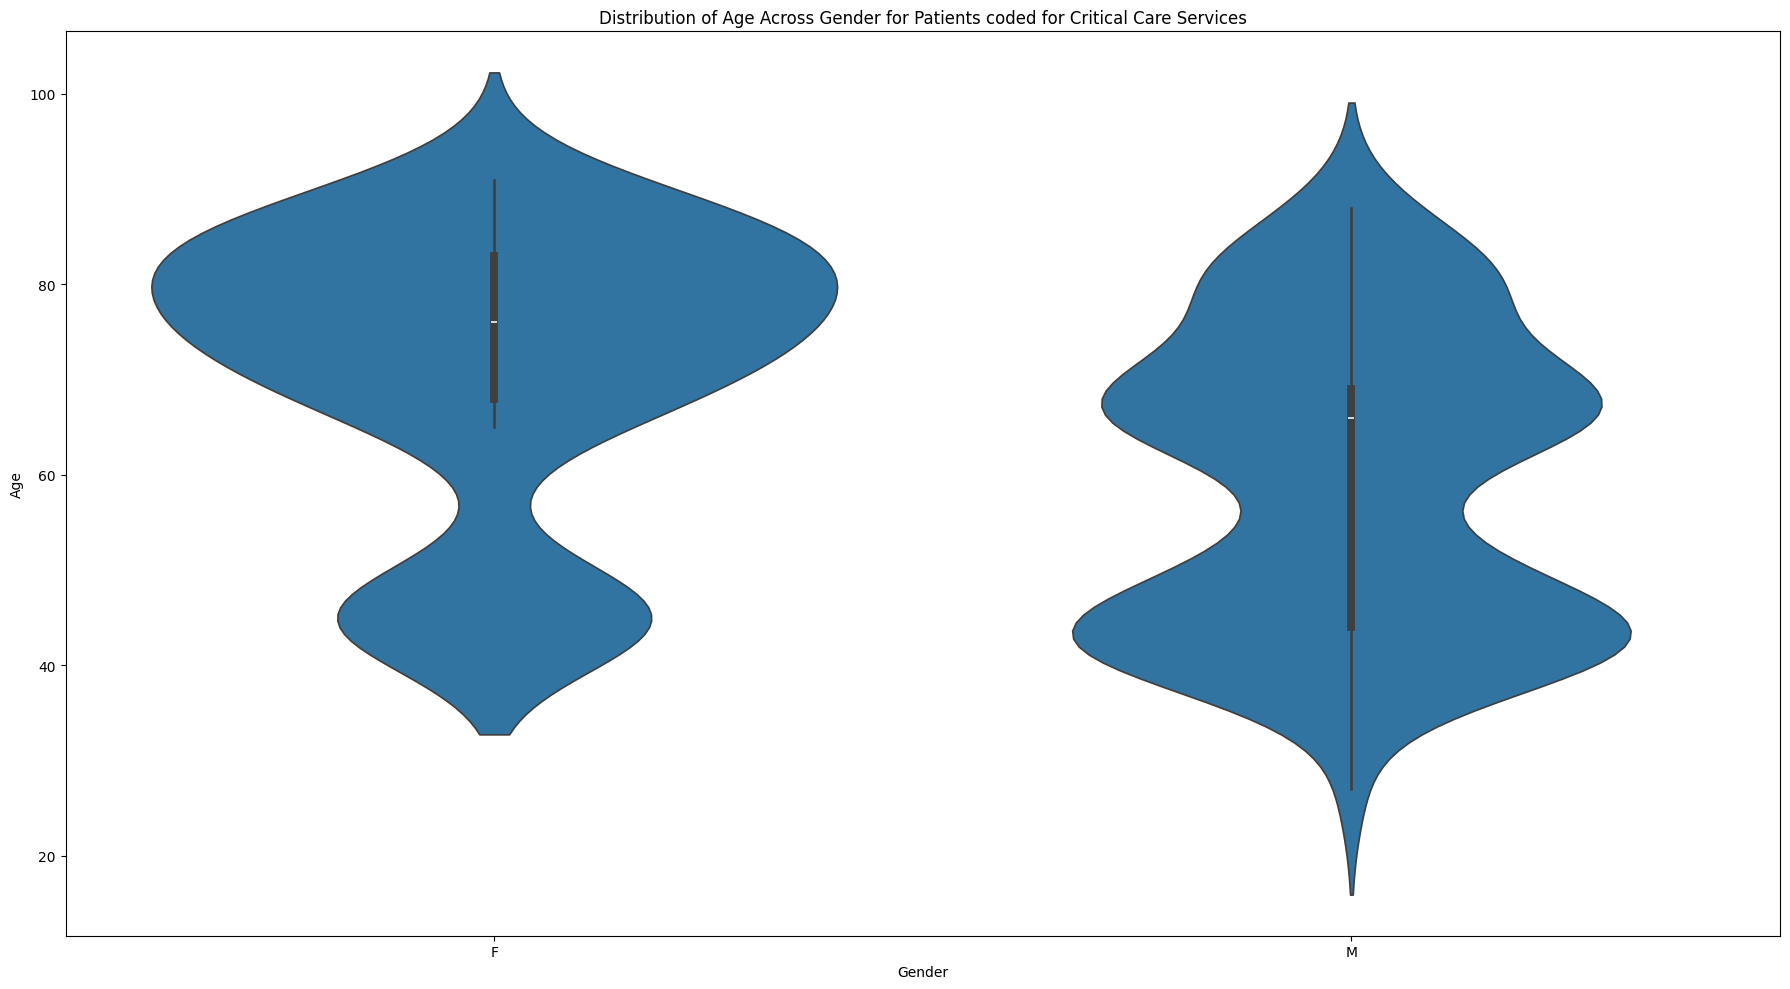

In [13]:
plt.figure(figsize=(18, 10))

sns.violinplot(data=patient_cpt_event_df, x='gender', y='age')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Distribution of Age Across Gender for Patients coded for Critical Care Services')

plt.tight_layout()
plt.show()

In [14]:
admissions_df = pd.read_csv(path + r"\ADMISSIONS.csv")

admissions_df['insurance'].value_counts()

insurance
Medicare      98
Private       24
Medicaid       6
Government     1
Name: count, dtype: int64

In [15]:
cpt_admissions_merge = pd.merge(admissions_df, patient_cpt_event_df, on='subject_id')

In [16]:
## Bonus Package plotnine
from plotnine import ggplot, aes, geom_point, theme_minimal, labs, theme, element_text

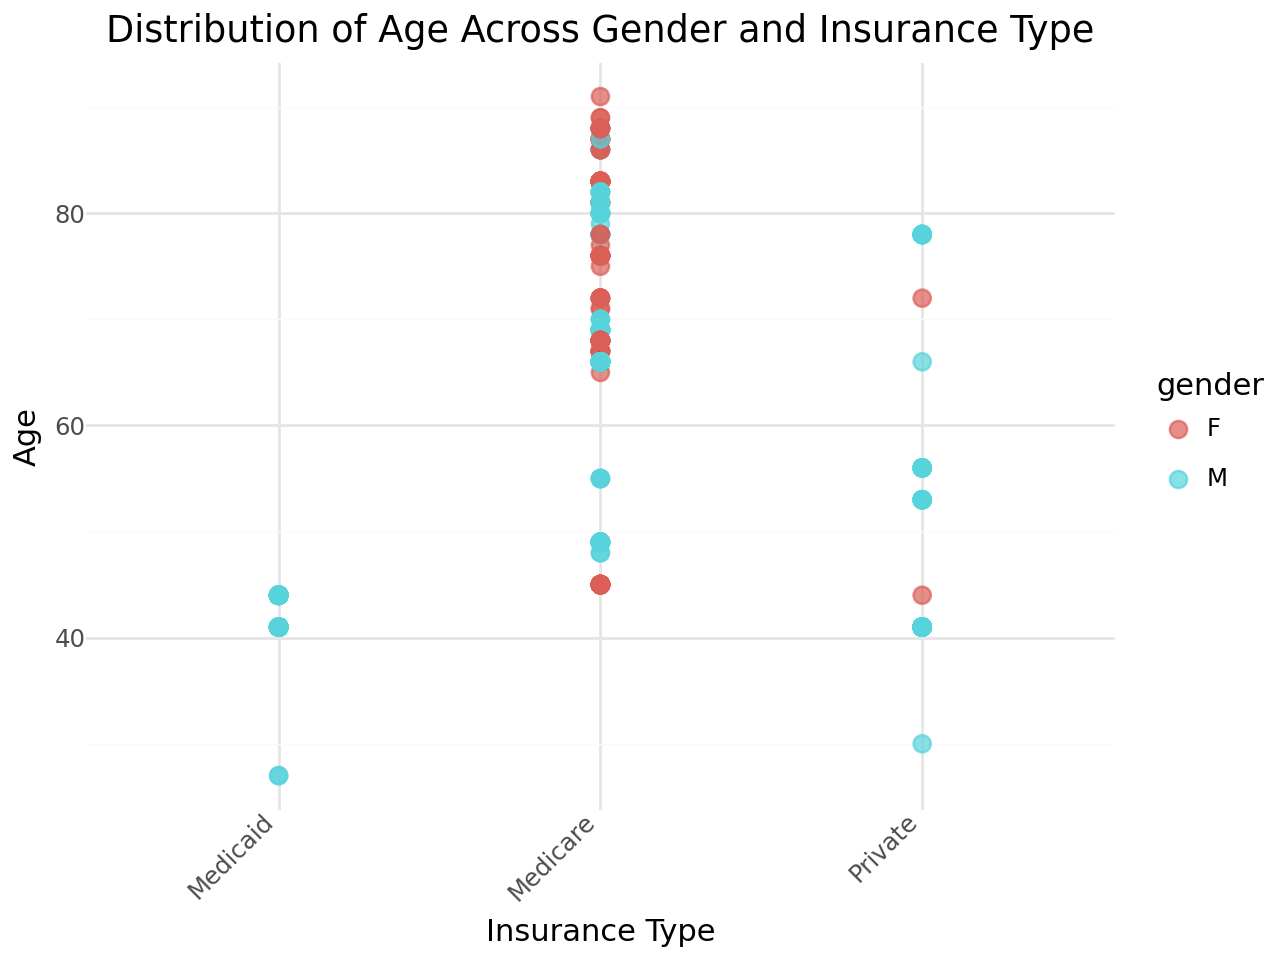

In [17]:
plot = (
    ggplot(cpt_admissions_merge, aes(x='insurance', y='age', color='gender')) +
    geom_point(size=3, alpha=0.7) +
    theme_minimal() +
    labs(
        title='Distribution of Age Across Gender and Insurance Type',
        x='Insurance Type',
        y='Age'
    ) +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

plot.show()

In [18]:
cpt_admissions_merge['admittime'] = pd.to_datetime(cpt_admissions_merge['admittime'])
cpt_admissions_merge['dischtime'] = pd.to_datetime(cpt_admissions_merge['dischtime'])

cpt_admissions_merge['length_of_stay'] = (cpt_admissions_merge['dischtime'] - cpt_admissions_merge['admittime']).dt.total_seconds() / 3600

In [19]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Survived', 'Deceased'])

survived_data = cpt_admissions_merge[cpt_admissions_merge['hospital_expire_flag'] == 0]
deceased_data = cpt_admissions_merge[cpt_admissions_merge['hospital_expire_flag'] == 1]

fig.add_trace(
    go.Scatter(
        x=survived_data['age'],
        y=survived_data['length_of_stay'],
        mode='markers',
        marker=dict(
            color=survived_data['gender'].apply(lambda x: 'blue' if x == 'M' else 'pink'),
            size=8
        ),
        name='Male' if survived_data['gender'].iloc[0] == 'M' else 'Female',
        text=survived_data['gender'],
        hovertemplate='<b>Gender: %{text}</b><br>Age: %{x}<br>LOS: %{y:.2f} hours',
        showlegend=True 
    ),
    row=1,
    col=1
)

for gender, color in zip(['M', 'F'], ['blue', 'pink']):
    mean_los_survived = survived_data[survived_data['gender'] == gender]['length_of_stay'].mean()
    fig.add_trace(
        go.Scatter(
            x=[survived_data['age'].min(), survived_data['age'].max()],
            y=[mean_los_survived, mean_los_survived],
            mode='lines',
            line=dict(dash='dot', color=color),
            name='Mean LOS (Male)' if gender == 'M' else 'Mean LOS (Female)',
            showlegend=True 
        ),
        row=1,
        col=1
    )

fig.add_trace(
    go.Scatter(
        x=deceased_data['age'],
        y=deceased_data['length_of_stay'],
        mode='markers',
        marker=dict(
            color=deceased_data['gender'].apply(lambda x: 'blue' if x == 'M' else 'pink'),
            size=8
        ),
        name='Male' if 'M' in deceased_data['gender'].values else 'Female',
        text=deceased_data['gender'],
        hovertemplate='<b>Gender: %{text}</b><br>Age: %{x}<br>LOS: %{y:.2f} hours',
        showlegend=True
    ),
    row=1,
    col=2
)

for gender, color in zip(['M', 'F'], ['blue', 'pink']):
    mean_los_deceased = deceased_data[deceased_data['gender'] == gender]['length_of_stay'].mean()
    fig.add_trace(
        go.Scatter(
            x=[deceased_data['age'].min(), deceased_data['age'].max()],
            y=[mean_los_deceased, mean_los_deceased],
            mode='lines',
            line=dict(dash='dot', color=color),
            name='Mean LOS (Male)' if gender == 'M' else 'Mean LOS (Female)',
            showlegend=False
        ),
        row=1,
        col=2
    )

fig.update_layout(
    title="Length of Stay vs Age by Gender and Expiration Flag",
    showlegend=True
)

fig.show()